In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
models_name = [
    "basic-mini",
    "basic-base",
    "basic-large",
    "february_finetuned",
    "march_finetuned",
    "art-mini",
    "art-base",
    "art-large",
]
data = {}
for model_name in models_name:
    data[model_name] = {}
    data[model_name]["metrics"] = pd.read_csv(f"../../benchmarks/multilingual_results_{model_name}.csv")
    data[model_name]["positions"] = json.load(open(f"../../benchmarks/positions_specific_focus_{model_name}.json"))

In [3]:
def getdf(model_name, focus=None):
    if focus is None:
        df = data[model_name]["metrics"] 
    else:
        df = data[model_name]["metrics"][data[model_name]["metrics"]["focus"] == focus]
    df["model_name"] = model_name
    return df

def getjson(model_name, focus):
    if focus is None:
        positions_merged = {}
        for lang in data[model_name]["positions"]:
            positions_merged[lang] = []
            for focus in data[model_name]["positions"][lang]:
                positions_merged[lang].extend(data[model_name]["positions"][lang][focus])
        return positions_merged
    else:
        positions = {}
        for lang in data[model_name]["positions"]:
            positions[lang] = data[model_name]["positions"][lang][focus]
        return positions

def histogram_positions(model_name, focus):
    positions = getjson(model_name, focus)
    langs = list(positions.keys())
    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))
    for i, lang in enumerate(langs):
        axs[i].hist(positions[lang], bins=20, edgecolor='black')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Frequency")
    plt.suptitle(f"Histogram of positions for {model_name} and {focus}")
    plt.tight_layout()
    plt.show()

def cdf_positions(model_name, focus):
    positions = getjson(model_name, focus) 
    langs = list(positions.keys())

    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))

    if len(langs) == 1:
        axs = [axs]

    # Get overall max position
    max_position = 0
    for lang in langs:
        max_position = max(max_position, max(positions[lang]))

    for i, lang in enumerate(langs):
        data = np.sort(positions[lang])
        cdf = np.arange(1, len(data) + 1) / len(data)
        # Fill cdf with 1 so that the last point is at the max position
        
        while data[-1] < max_position:
            data = np.concatenate([data, [max_position]])
            cdf = np.concatenate([cdf, [1]])

        percentile_90 = np.percentile(data, 90)
        percentile_95 = np.percentile(data, 95)
        percentile_99 = np.percentile(data, 99)

        # Vlines for 90, 95, 99 percentile
        axs[i].vlines(percentile_90, 0, 1, color='r', linestyle='--', label='90th Percentile')
        axs[i].vlines(percentile_95, 0, 1, color='g', linestyle='--', label='95th Percentile')
        axs[i].vlines(percentile_99, 0, 1, color='y', linestyle='--', label='99th Percentile')
        

        axs[i].plot(data, cdf, linestyle='-', color='b', label='CDF')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Cumulative Frequency")
        axs[i].grid(True, linestyle='--', alpha=0.5)
        axs[i].set_xlim(0, max_position)
        axs[i].legend(loc='lower right')

    plt.suptitle(f"CDF of positions for {model_name} and {focus}")
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [4]:
# Add to the metrics the percentile 50, 90, 95, 99
positions_per_model_per_lang = {}
for model_name in models_name:
    positions_per_model_per_lang[model_name] = {}
    print("Done ", model_name)
    for focus in data[model_name]["metrics"]["focus"].unique():
        if focus=="all_focus":
            continue
        df = getdf(model_name, focus)
        json_data = getjson(model_name, focus)
        for lang in json_data.keys():
            positions = json_data[lang]
            # Create a boolean mask for the correct rows
            mask = (df["model_name"] == model_name) & (df["lang"] == lang)
            # Apply the mask to update the percentiles
            df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
            df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
            df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
            df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
            df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

    # Add for all_focus
    df = getdf(model_name, None)
    json_data = getjson(model_name, None)
    for lang in json_data.keys():
        positions = json_data[lang]
        positions_per_model_per_lang[model_name][lang] = positions
        # Create a boolean mask for the correct rows
        mask = (df["model_name"] == model_name) & (df["lang"] == lang)
        # Apply the mask to update the percentiles
        df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
        df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
        df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
        df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
        df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

Done  basic-mini
Done  basic-base
Done  basic-large
Done  february_finetuned
Done  march_finetuned
Done  art-mini
Done  art-base


C:\Users\victo\AppData\Local\Temp\ipykernel_27040\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name
C:\Users\victo\AppData\Local\Temp\ipykernel_27040\875097596.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
C:\Users\victo\AppData\Local\Temp\ipykernel_27040\875097596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Done  art-large


C:\Users\victo\AppData\Local\Temp\ipykernel_27040\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name
C:\Users\victo\AppData\Local\Temp\ipykernel_27040\875097596.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
C:\Users\victo\AppData\Local\Temp\ipykernel_27040\875097596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [5]:
all_focus_df = pd.concat([getdf(model_name, "all_focus") for model_name in models_name])
all_focus_df

C:\Users\victo\AppData\Local\Temp\ipykernel_27040\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name


,lang,focus,loss,average_position,mrr,recall@1,recall@5,recall@10,nDCG@1,nDCG@5,nDCG@10,model_name,percentile_50,percentile_75,percentile_90,percentile_95,percentile_99
4,FR,all_focus,3.212070,22.440508,0.375068,0.249967,0.506223,0.645225,0.249967,0.383883,0.429479,basic-mini,6.0,25.00,78.0,134.00,223.05
9,EN,all_focus,2.014006,7.820168,0.533790,0.401566,0.685610,0.824177,0.401566,0.550926,0.595932,basic-mini,3.0,8.00,21.0,37.00,109.23
14,NL,all_focus,4.068309,30.460115,0.267472,0.147865,0.392144,0.514081,0.147865,0.273970,0.313410,basic-mini,11.0,43.00,103.7,151.70,267.47
4,FR,all_focus,1.337325,14.970489,0.459432,0.325652,0.598247,0.708395,0.325652,0.473705,0.510153,basic-base,4.0,16.00,51.0,84.05,174.05
9,EN,all_focus,0.549765,4.394852,0.646741,0.508839,0.814597,0.904872,0.508839,0.675704,0.705188,basic-base,2.0,4.00,11.0,18.00,47.00
14,NL,all_focus,1.833276,16.913578,0.373640,0.233332,0.528469,0.678902,0.233332,0.387257,0.436057,basic-base,5.0,18.00,53.0,90.40,166.11
4,FR,all_focus,0.890211,13.029739,0.477068,0.340812,0.640918,0.736227,0.340812,0.500155,0.530997,basic-large,3.0,13.00,43.0,73.00,157.46
9,EN,all_focus,0.272292,4.074256,0.665969,0.530846,0.843441,0.909378,0.530846,0.700294,0.721489,basic-large,2.0,4.00,11.0,19.00,39.94
14,NL,all_focus,1.315949,17.049171,0.380494,0.243245,0.543767,0.683962,0.243245,0.397551,0.442820,basic-large,5.0,17.00,55.7,93.00,188.41
4,FR,all_focus,0.349506,2.634336,0.744311,0.619004,0.897613,0.951449,0.619004,0.775328,0.792792,february_finetuned,1.0,2.00,6.0,11.00,22.00


In [6]:
# 	lang	focus	loss	average_position	mrr	recall@1	recall@5	recall@10	nDCG@1	nDCG@5	nDCG@10	model_name	percentile_50	percentile_75	percentile_90	percentile_95	percentile_99
def get_table_lang(lang):
    table_LANG = pd.DataFrame(all_focus_df[all_focus_df["lang"] == lang])
    # Remove columns
    table_LANG = table_LANG.drop(columns=["loss", "lang", "focus", "nDCG@1", "percentile_99"])
    # Columns for training_data
    table_LANG["training_data"] = [
        "N/A",
        "N/A",
        "N/A",
        "cap-FR-1",
        "cap-FR-2 \& ico-FR",
        "cap-TRI \& ico-TRI",
        "cap-TRI \& ico-TRI",
        "cap-TRI \& ico-TRI",
    ]
    table_LANG["pretrained_model"] = [
        "B/32",
        "L/14",
        "L/14@336px",
        "L/14",
        "L/14",
        "B/32",
        "L/14",
        "L/14@336px",
    ]
    # Round specific columns
    round_factor = 3
    numeric_columns = [
        "average_position",
        "mrr",
        "recall@1",
        "recall@5",
        "recall@10",
        "nDCG@5",
        "nDCG@10",
        "percentile_50",
        "percentile_75",
        "percentile_90",
        "percentile_95"
    ]
    for col in numeric_columns:
        table_LANG[col] = table_LANG[col].round(round_factor)
        if col in ["average_position", "percentile_50", "percentile_75", "percentile_90", "percentile_95"]:
            best_value = table_LANG[col].min()
        else:
            best_value = table_LANG[col].max()
        # Bold the value if it is the best in the column
        table_LANG[col] = table_LANG[col].apply(lambda x: f"\\textbf{{{x}}}" if x == best_value else str(x))
    # For each numeric column, bold the value
    # Reorder columns
    table_LANG = table_LANG[["training_data", "pretrained_model", "model_name", "average_position", "mrr", "recall@1", "recall@5", "recall@10", "nDCG@5", "nDCG@10", "percentile_50", "percentile_75", "percentile_90", "percentile_95"]]
    # Rename columns
    table_LANG = table_LANG.rename(columns={
        "training_data": "Dataset",
        "pretrained_model": "ViT",
        "model_name": "Model",
        "average_position": "Avg. Pos.",
        "mrr": "MRR",
        "recall@1": "Recall@1",
        "recall@5": "Recall@5",
        "recall@10": "Recall@10",
        "nDCG@5": "nDCG@5",
        "nDCG@10": "nDCG@10",
        "percentile_50": "P50",
        "percentile_75": "P75",
        "percentile_90": "P90",
        "percentile_95": "P95"
    })
    # drop index
    table_LANG = table_LANG.reset_index(drop=True)
    return table_LANG

table_FR = get_table_lang("FR")
table_EN = get_table_lang("EN")
table_NL = get_table_lang("NL")

In [14]:
# print as latex table
table_FR.to_csv("../../CSV/table_FR.csv", index=False)

In [15]:
table_EN.to_csv("../../CSV/table_EN.csv", index=False)

In [16]:
table_NL.to_csv("../../CSV/table_NL.csv", index=False)

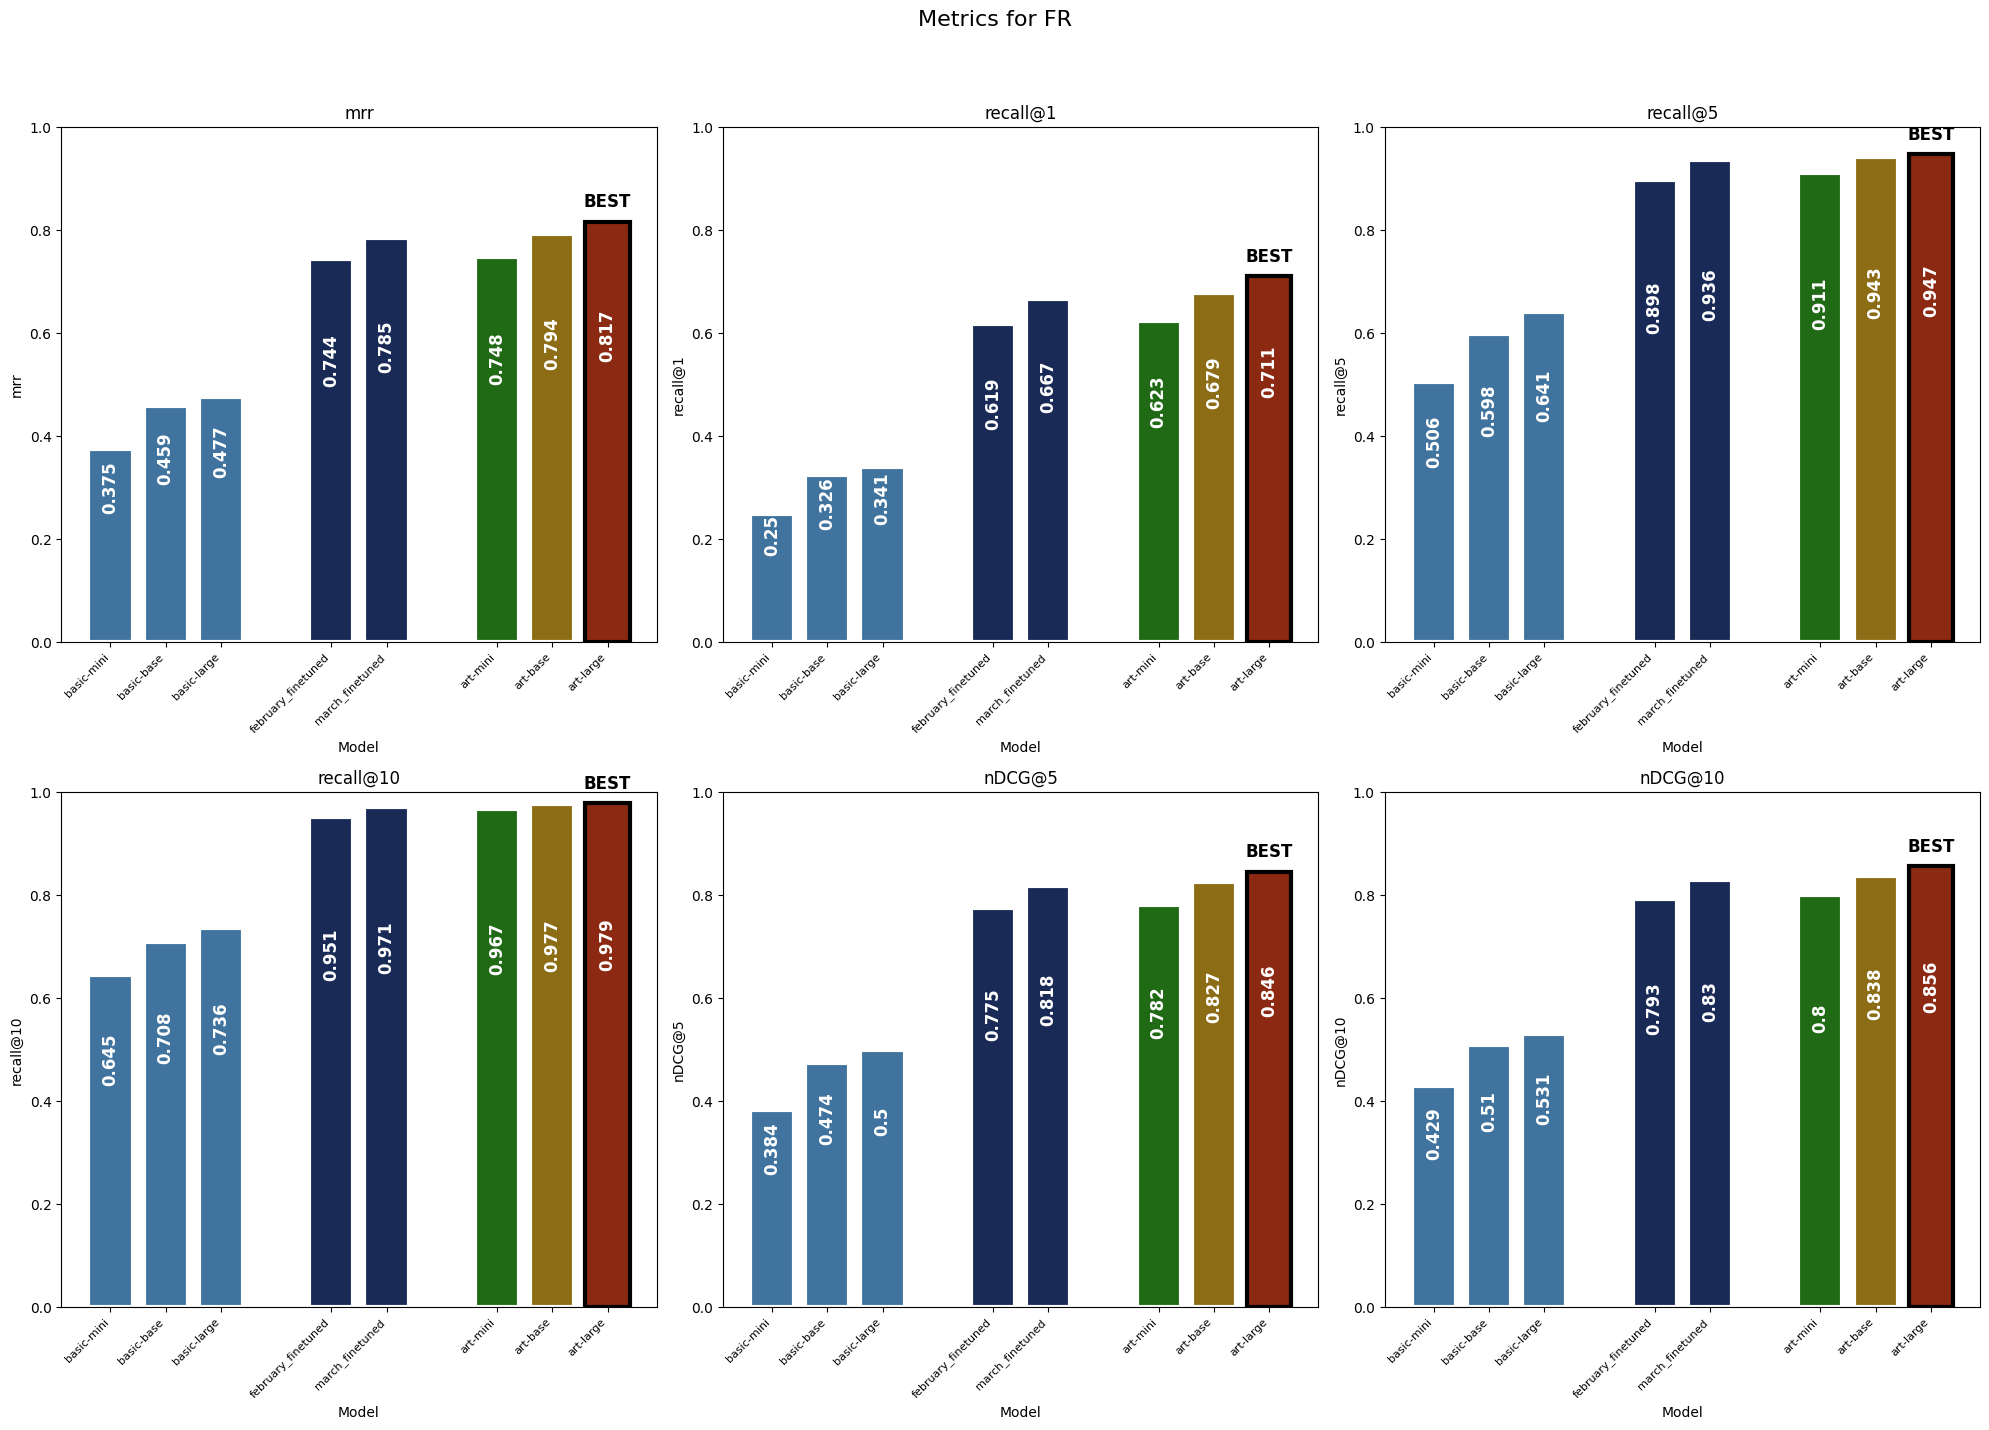

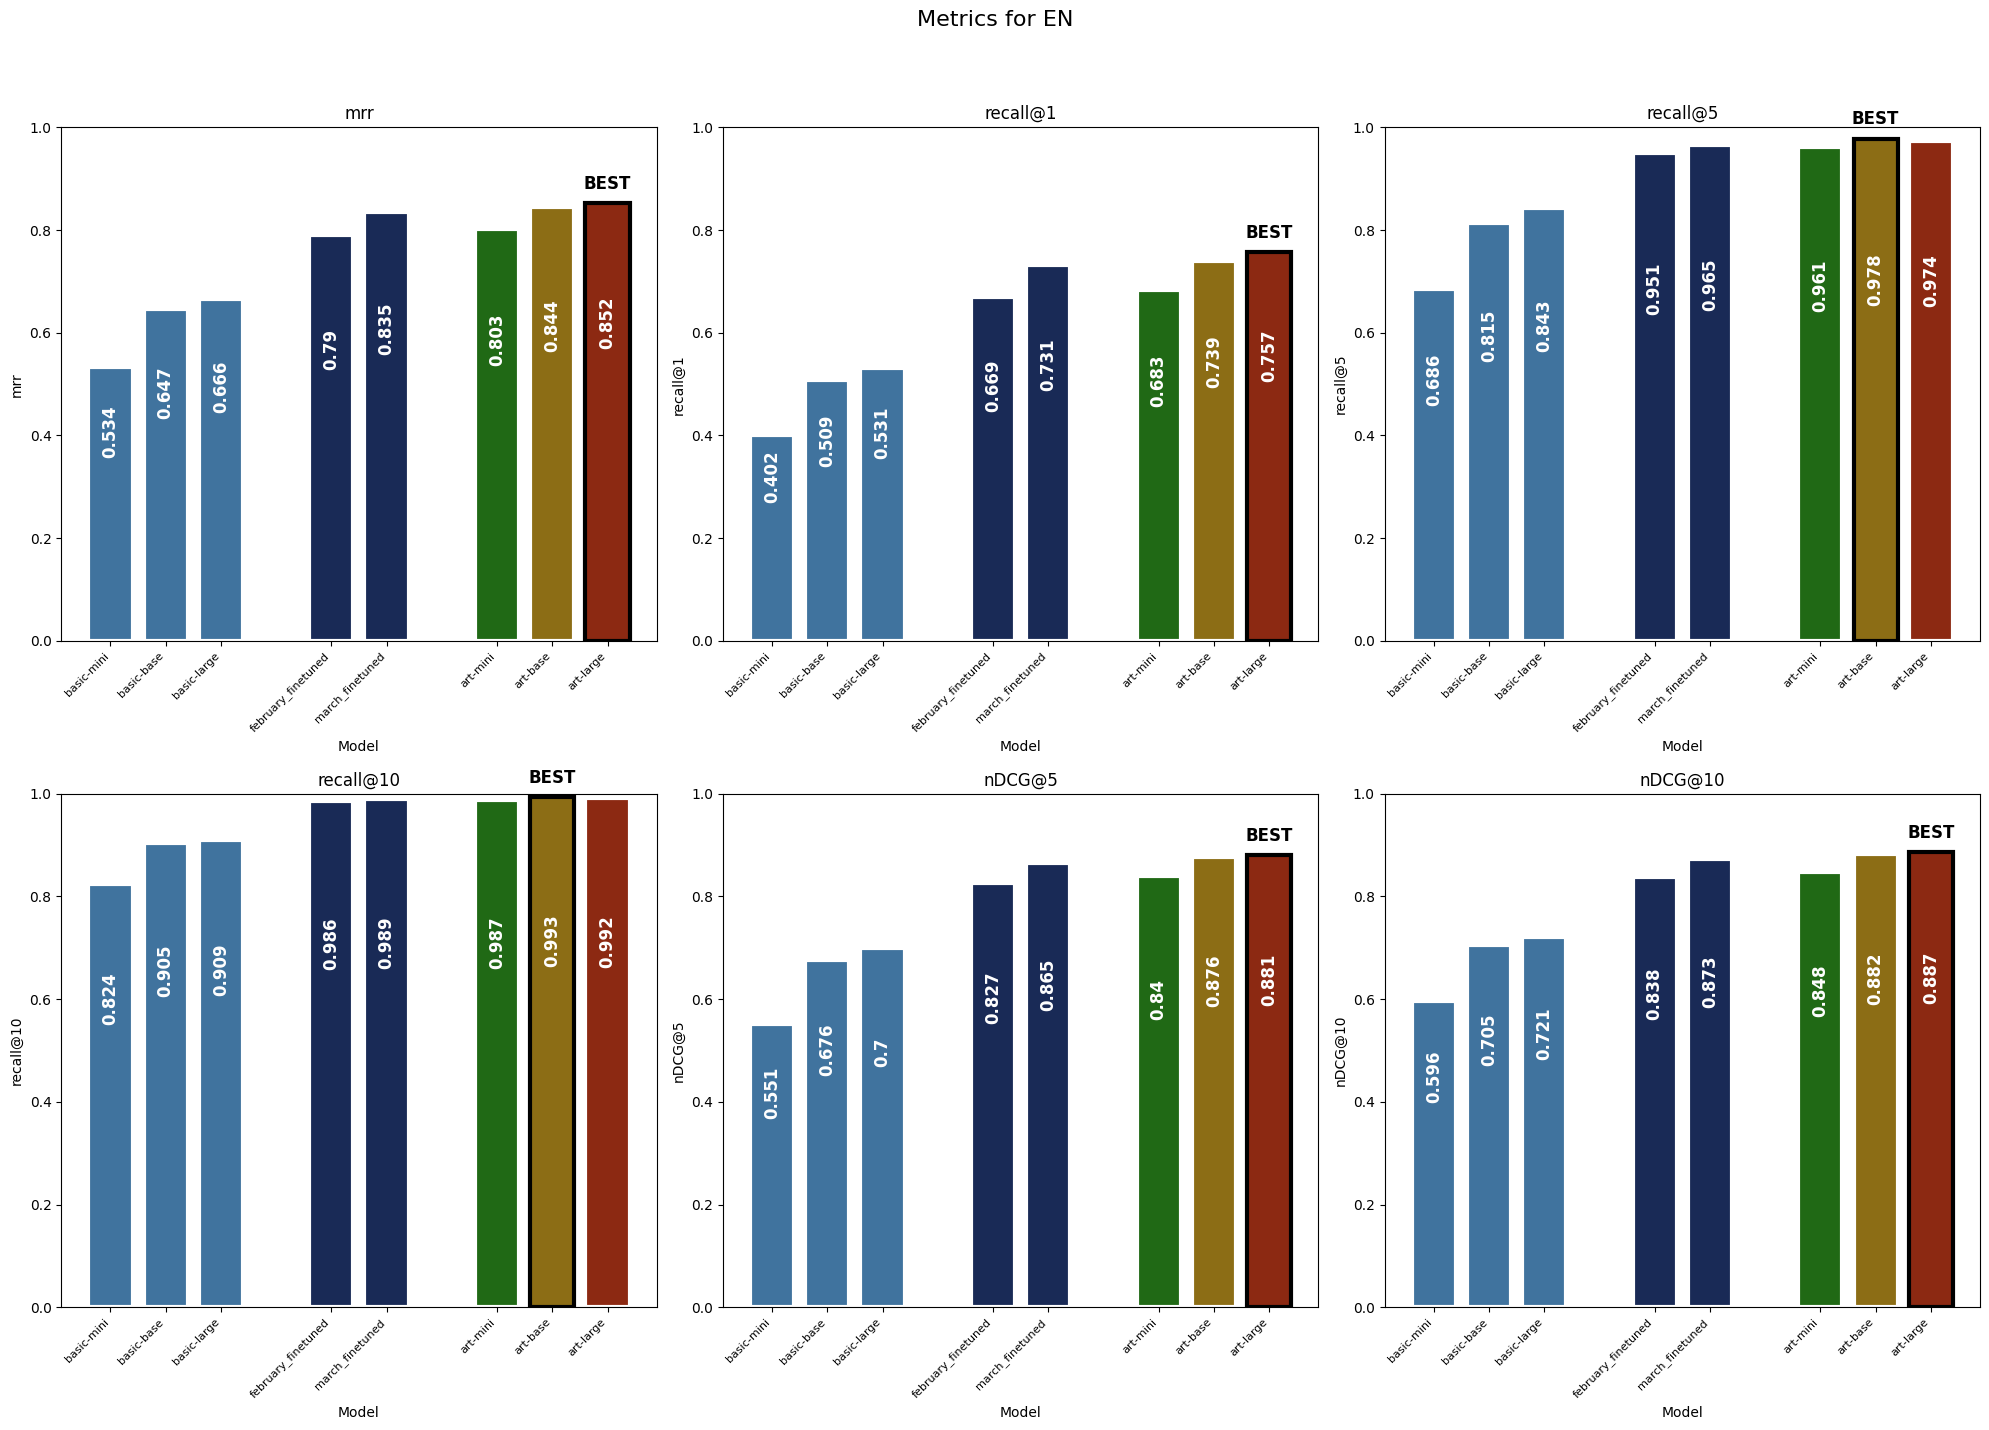

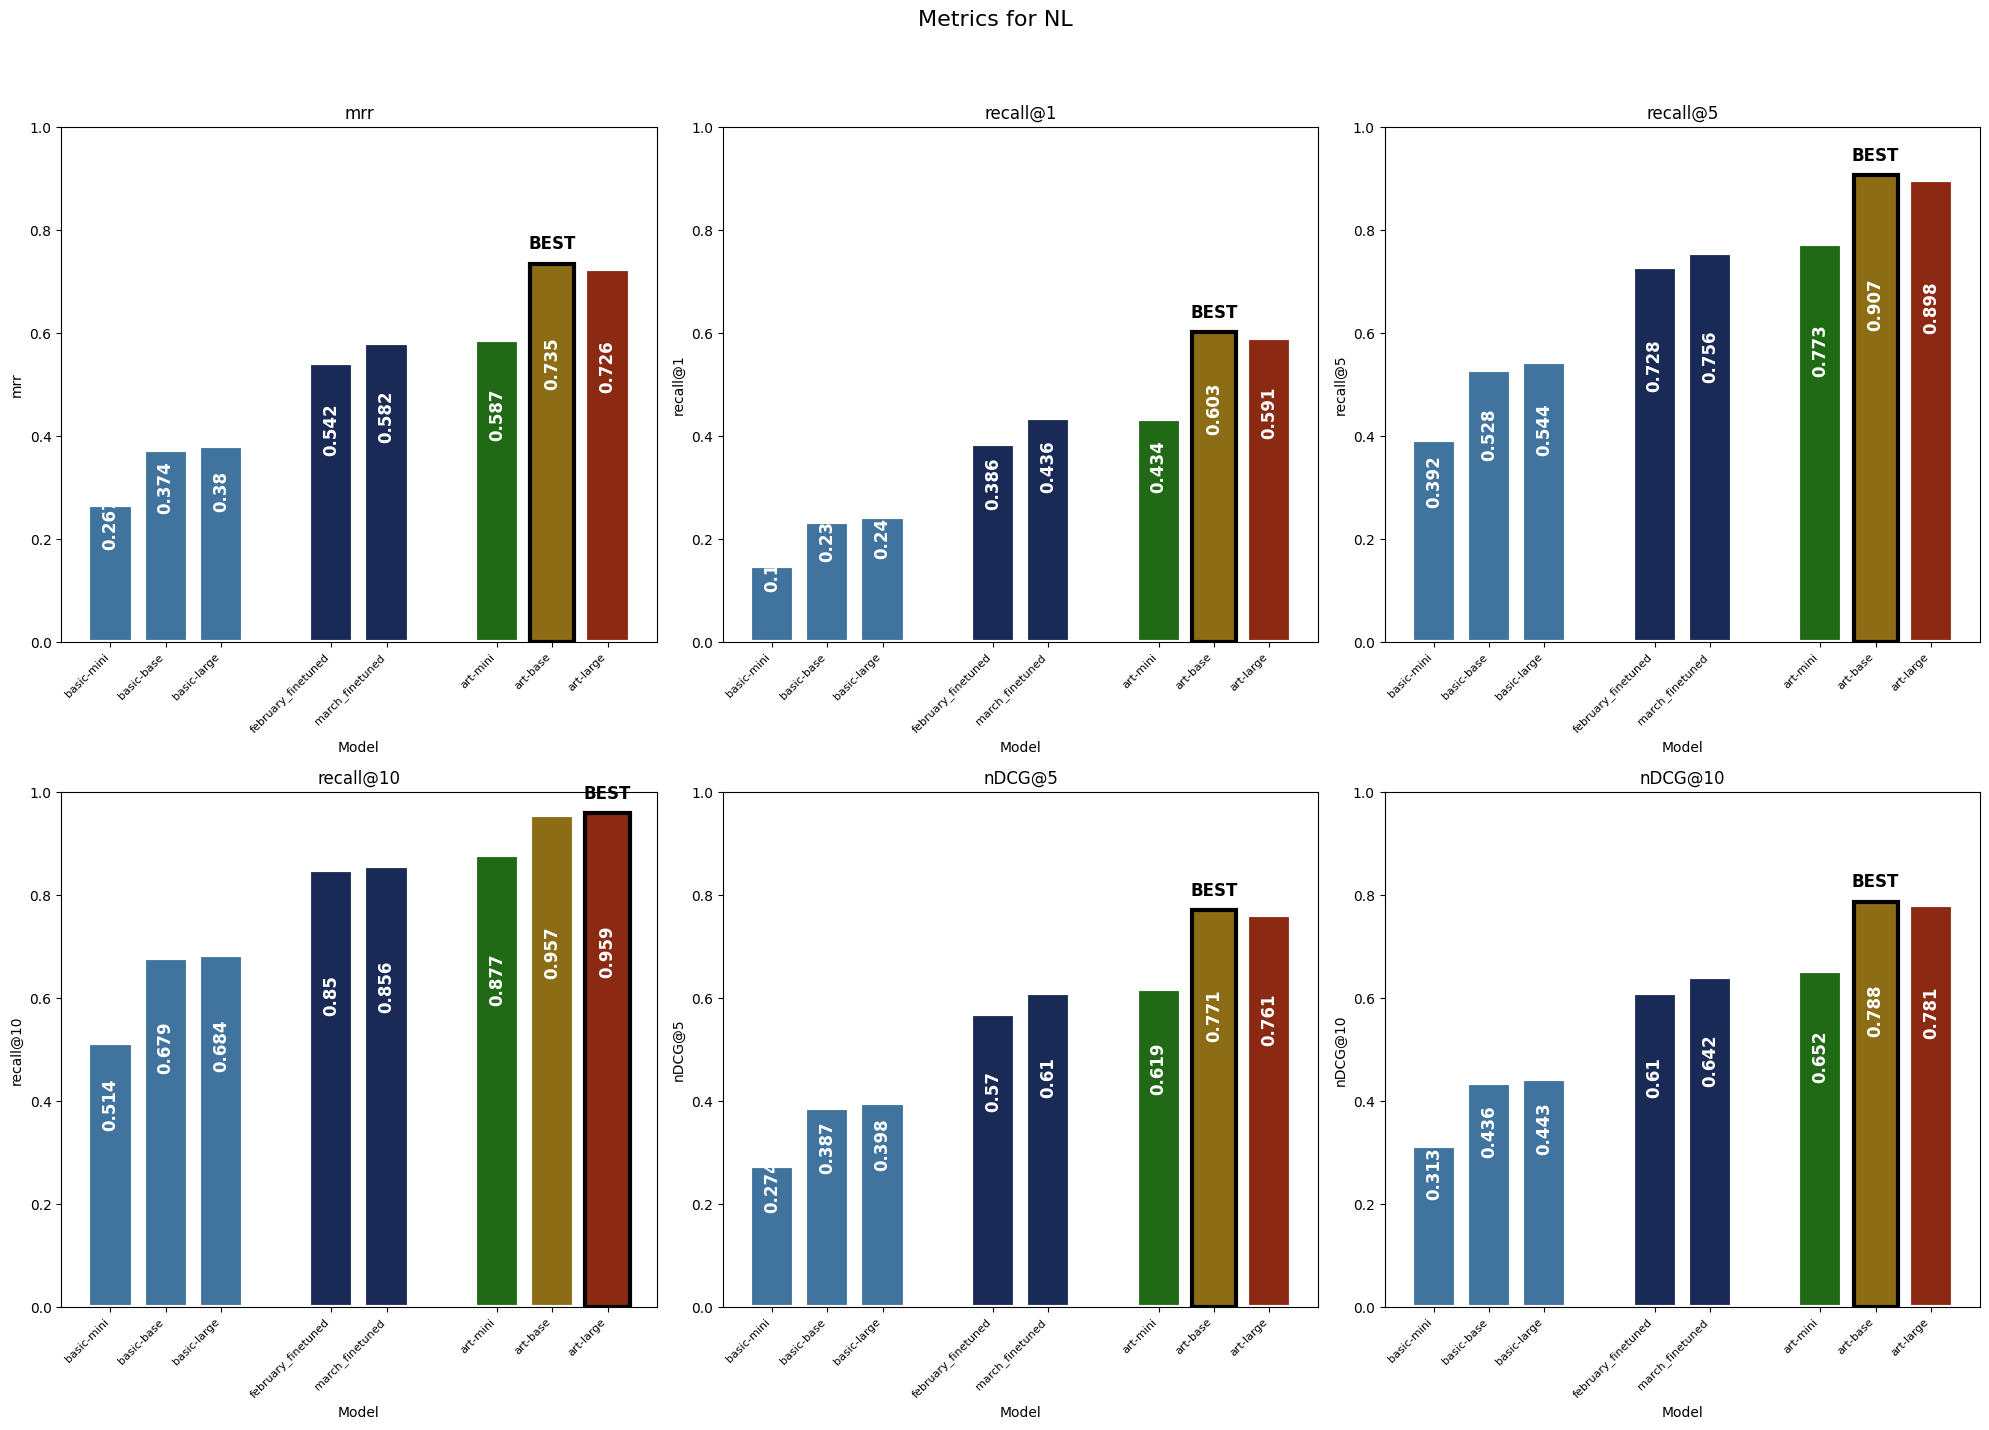

In [17]:
def plot_metrics_per_model_per_lang(lang):
    metrics = [
        "mrr",
        "recall@1",
        "recall@5",
        "recall@10",
        "nDCG@5",
        "nDCG@10"
    ]
    # 6 subplots, 1 row, 6 columns
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))  

    fig.suptitle(f"Metrics for {lang}", fontsize=16)

    # Iterate over the metrics and models
    for i, metric in enumerate(metrics):
        ax = axs[i // 3, i % 3] 
        bar_width = 0.8
        bar_positions = [0,1,2, 4,5, 7,8,9]

        bar_values = []
        for j, model_name in enumerate(models_name):
            df = all_focus_df[(all_focus_df["lang"] == lang) & (all_focus_df["model_name"] == model_name)]
            if not df.empty:
                bar_values.append(df[metric].values[0])
            else:
                bar_values.append(0)
        
        best_value_index = np.argmax(bar_values)
        # Highlight the best value in the bar chart
        edge_colors = ["#ffffff"] * len(bar_values)
        edge_colors[best_value_index] = "#000"

        ax.bar(bar_positions, bar_values, width=bar_width, alpha=1.0, color=["#40739e", "#40739e", "#40739e", "#192a56", "#192a56", "#206915", "#8c6d15", "#8c2912"], label=metric, edgecolor=edge_colors, linewidth=3)
        # Add the value in the center (middle vertical) of the bar
        for j, value in enumerate(bar_values):
            ax.text(bar_positions[j], value/1.5, str(round(value, 3)), ha='center', va='bottom', fontsize=12, color='white', rotation=90, fontweight='bold')
        # Add a "BEST" label on the best bar
        ax.text(bar_positions[best_value_index], bar_values[best_value_index] + 0.02, "BEST", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
        ax.set_title(metric, fontsize=12)
        ax.set_xlabel("Model", fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(models_name, rotation=45, ha="right", fontsize=8)
        ax.set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"../../figures/metrics_{lang}.pdf", dpi=300, bbox_inches='tight')

    plt.show()

for lang in ["FR", "EN", "NL"]:
    plot_metrics_per_model_per_lang(lang)

In [11]:
"""
Columns are:
lang	focus	loss	average_position	mrr	recall@1	recall@5	recall@10	nDCG@1	nDCG@5	nDCG@10
Plot mrr for each model, one color per lang
"""
def plot_metric_per_model_per_lang(metric_name, y_lim=None):
    langs = all_focus_df["lang"].unique()
    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))
    for i, lang in enumerate(langs):
        axs[i].bar(all_focus_df[all_focus_df["lang"] == lang]["model_name"], all_focus_df[all_focus_df["lang"] == lang][metric_name])
        axs[i].set_title(lang)
        axs[i].set_xlabel("Model")
        axs[i].set_ylabel(metric_name)
        axs[i].set_xticks(range(len(models_name)))
        axs[i].set_xticklabels(models_name, rotation=45)
        if y_lim is not None:
            axs[i].set_ylim(y_lim)
        # Add a text label on each bar
        for j, bar in enumerate(axs[i].patches):
            axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f}", ha="center", va="bottom")
    plt.suptitle(metric_name)
    plt.tight_layout()
    plt.savefig(f"../../figures/benchmarks_figures/{metric_name}.pdf")
    plt.show()

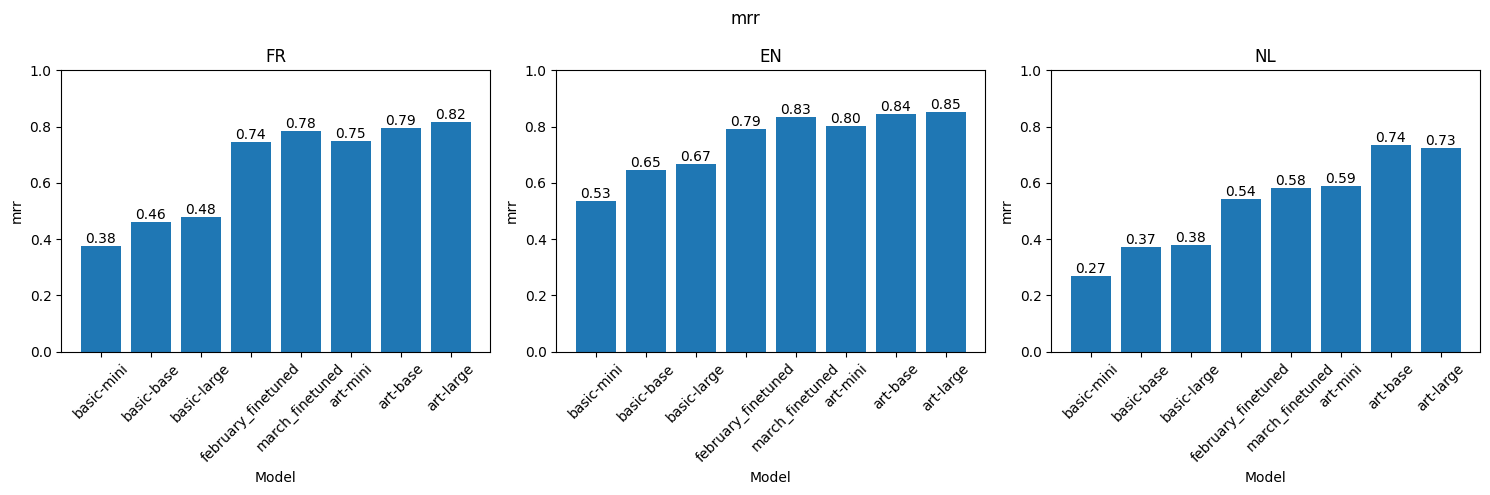

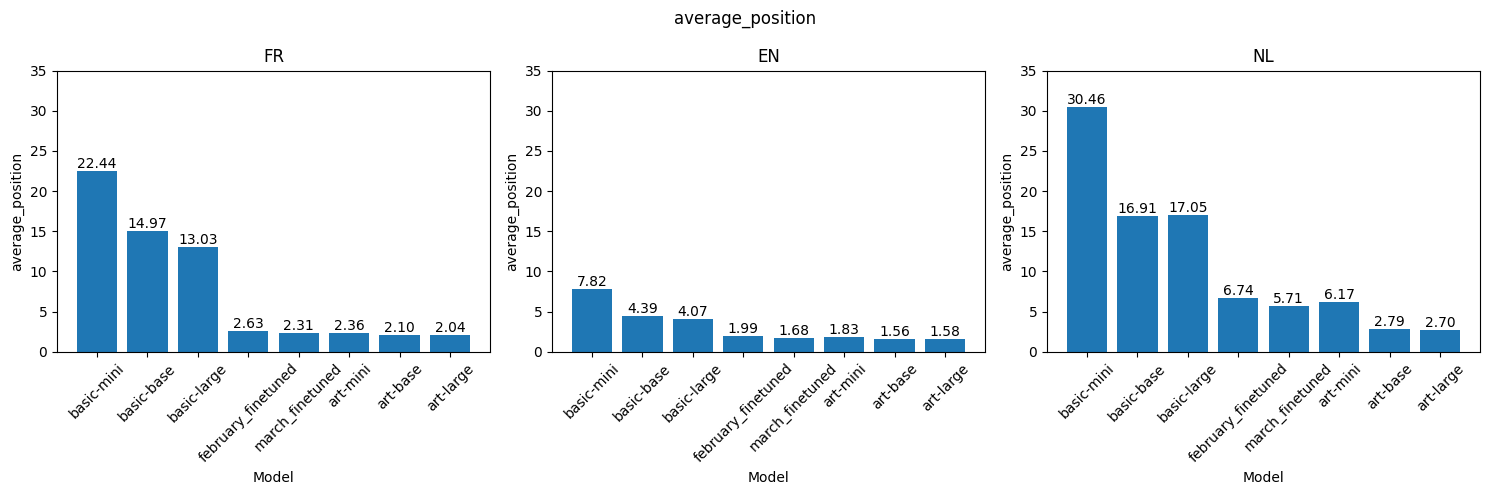

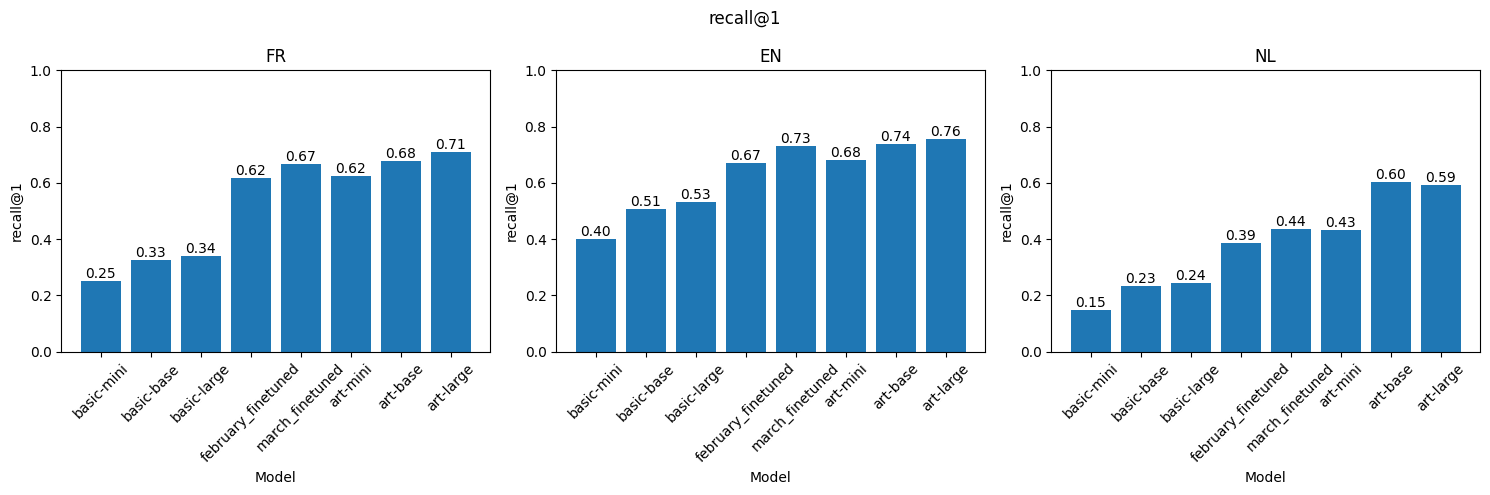

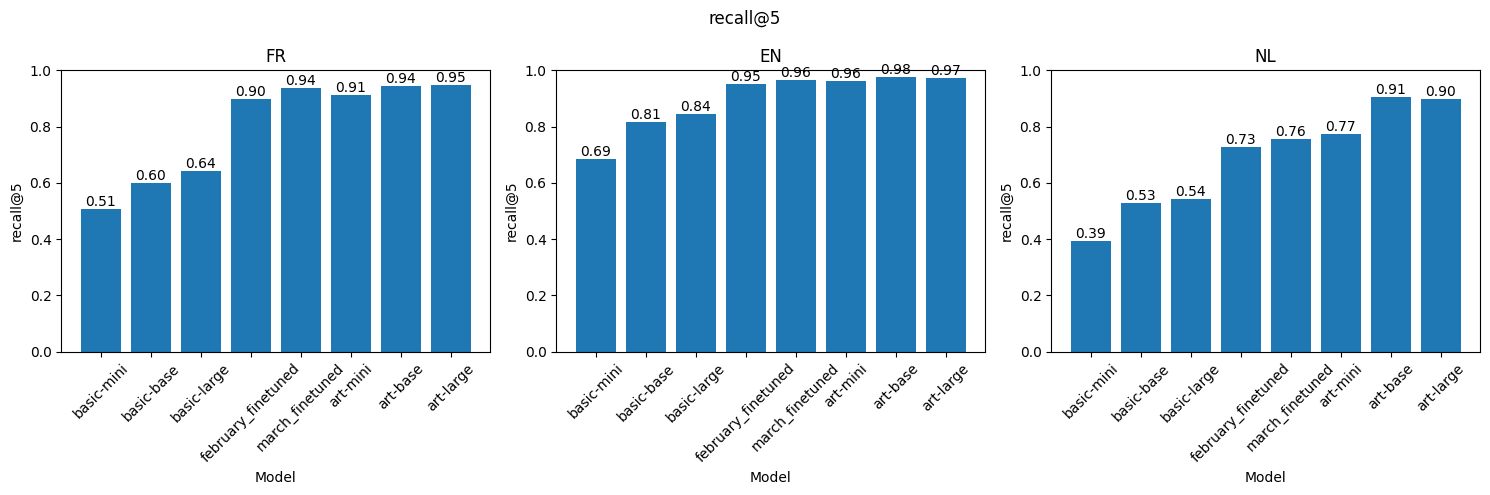

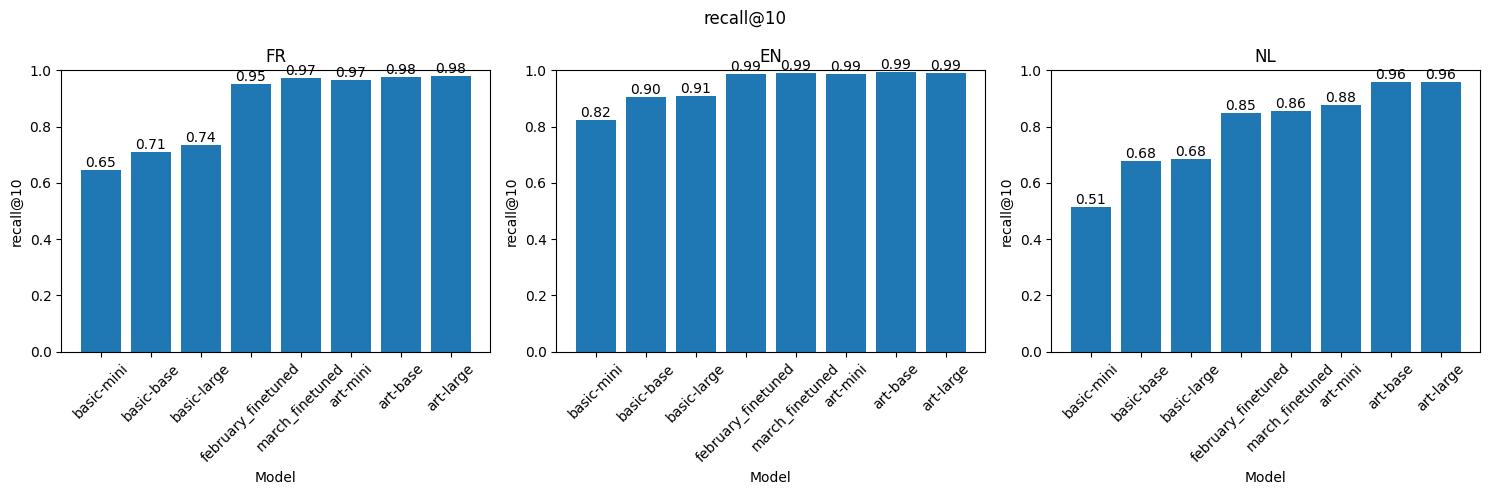

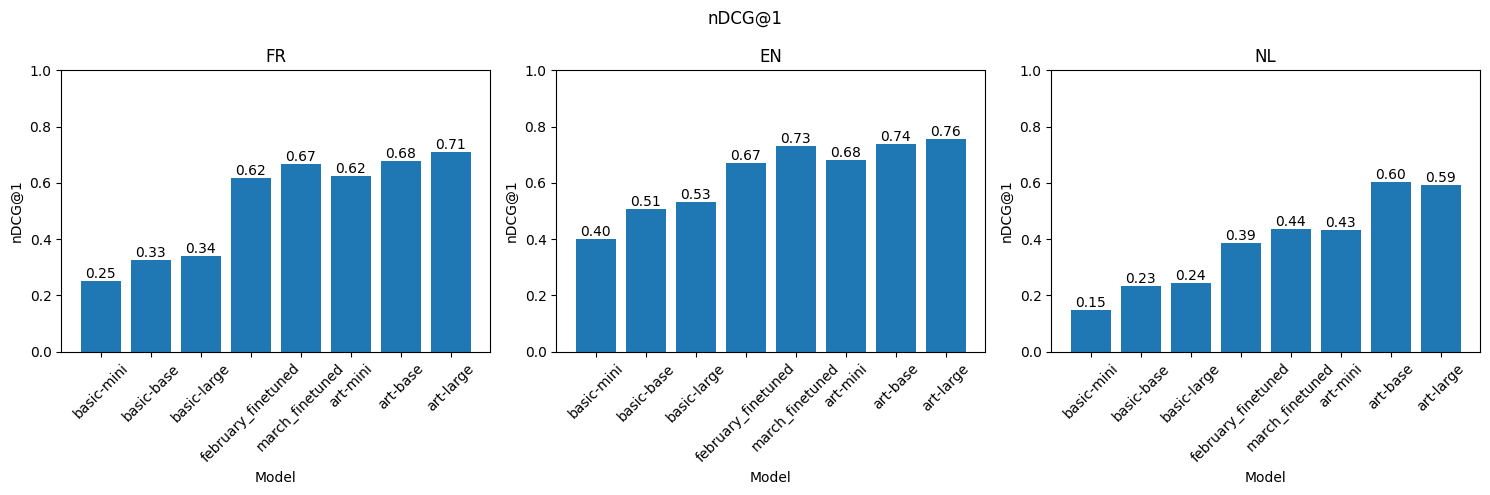

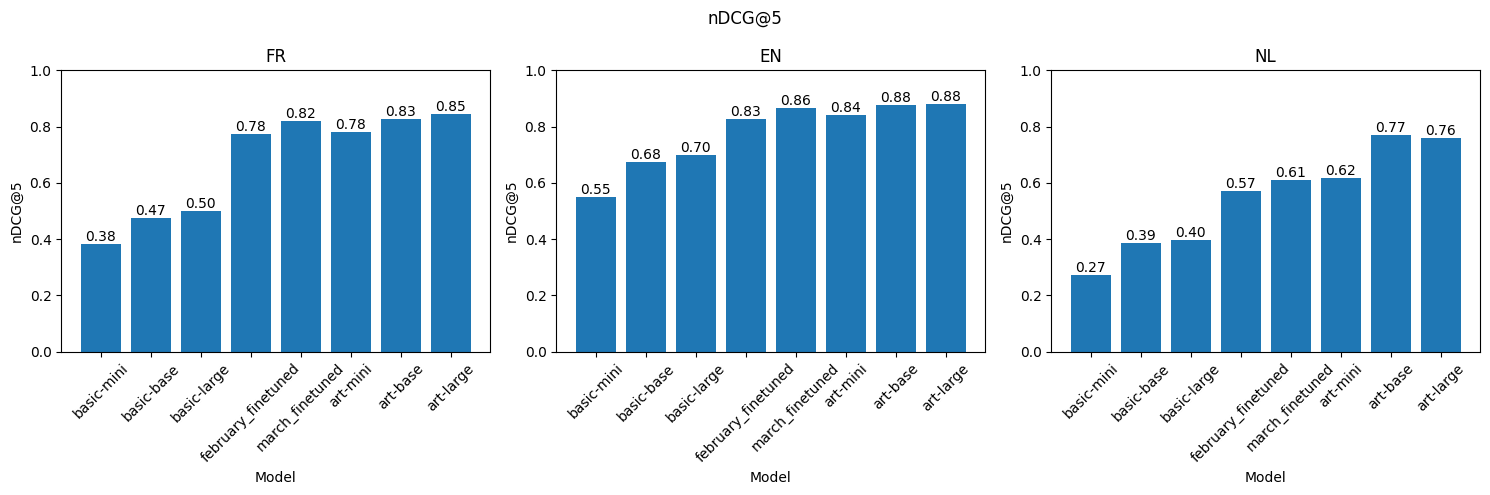

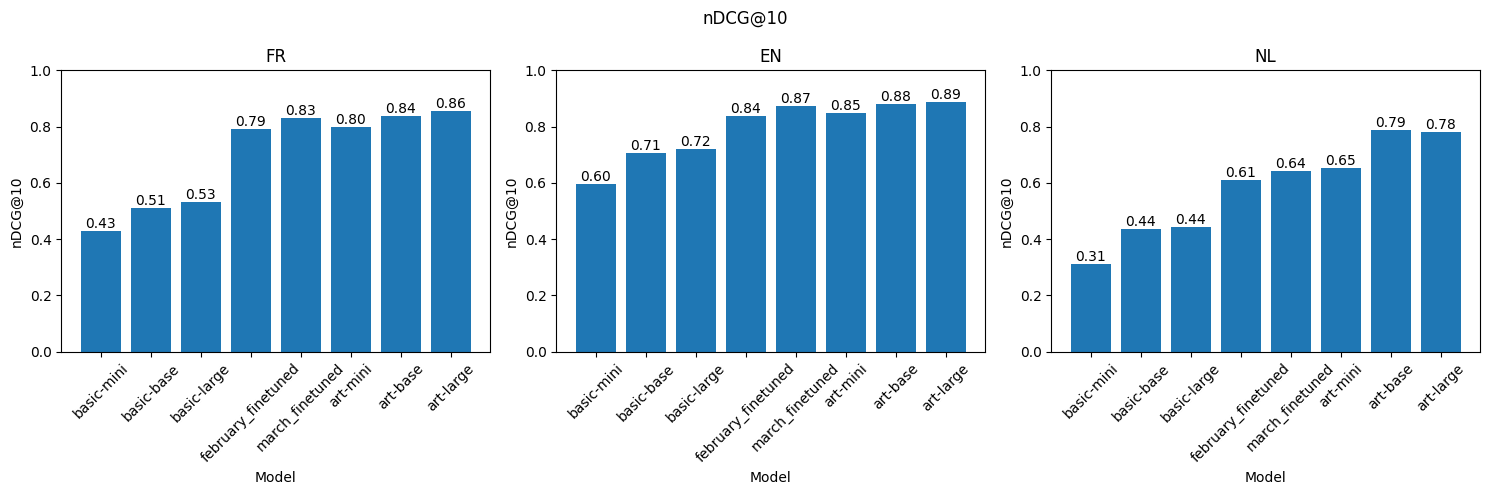

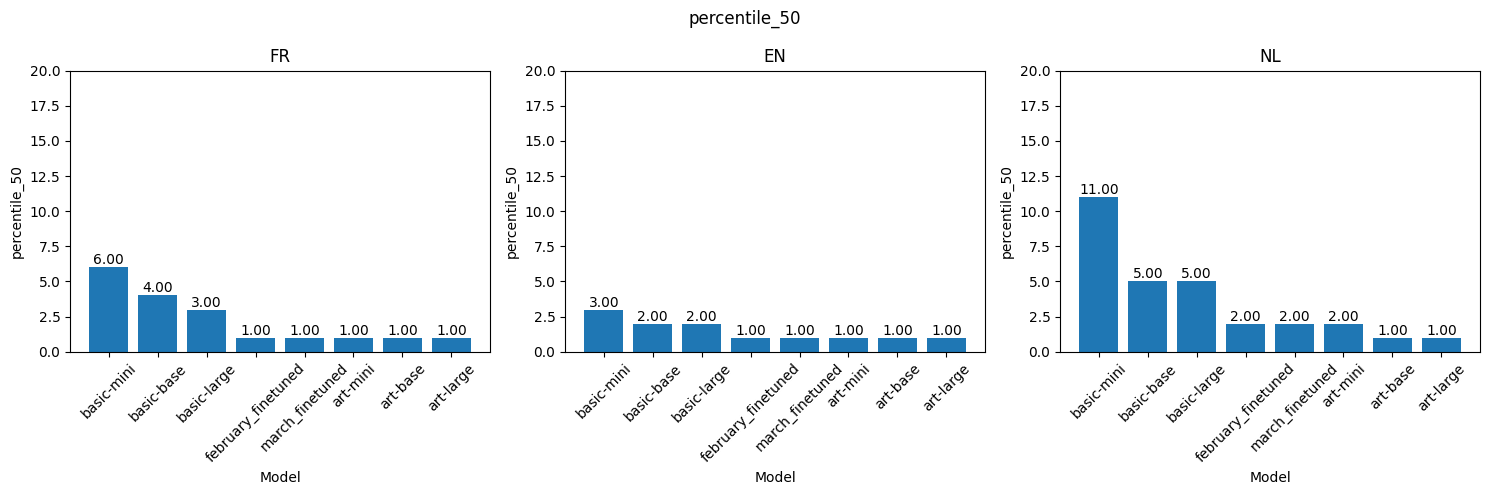

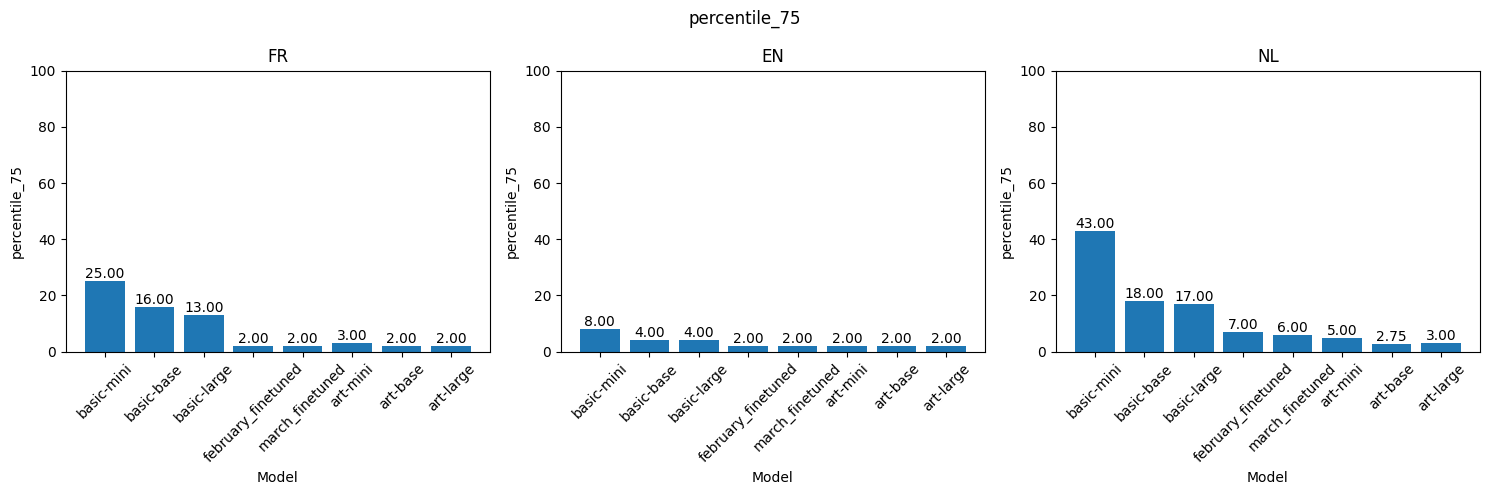

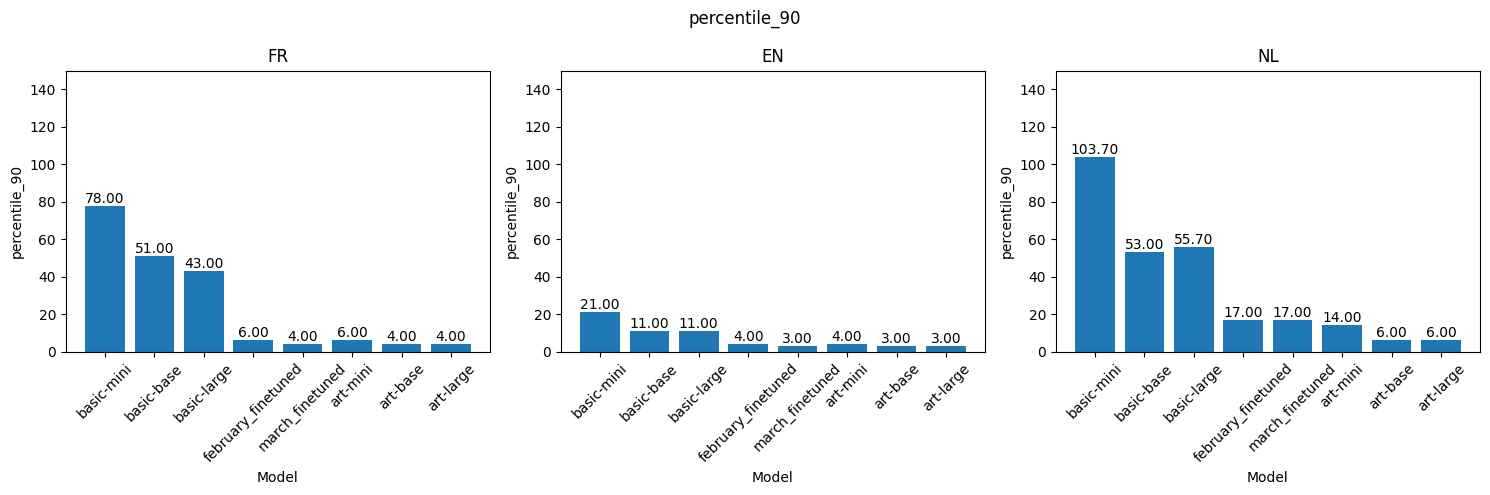

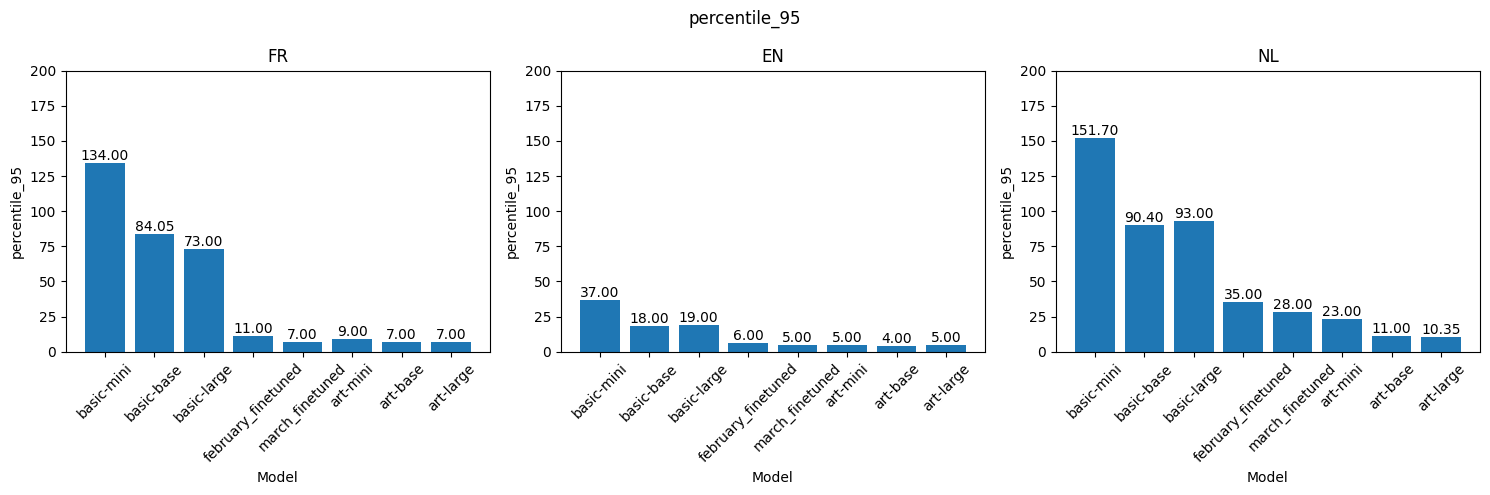

In [12]:
import os
os.makedirs("../../figures/benchmarks_figures", exist_ok=True)
metrics = {
    "mrr": (0, 1),
    "average_position": (0, 35),
    "recall@1": (0, 1),
    "recall@5": (0, 1),
    "recall@10": (0, 1),
    "nDCG@1": (0, 1),
    "nDCG@5": (0, 1),
    "nDCG@10": (0, 1),
    "percentile_50": (0, 20),
    "percentile_75": (0, 100),
    "percentile_90": (0, 150),
    "percentile_95": (0, 200),
}
for metric in metrics:
    plot_metric_per_model_per_lang(metric, metrics[metric])

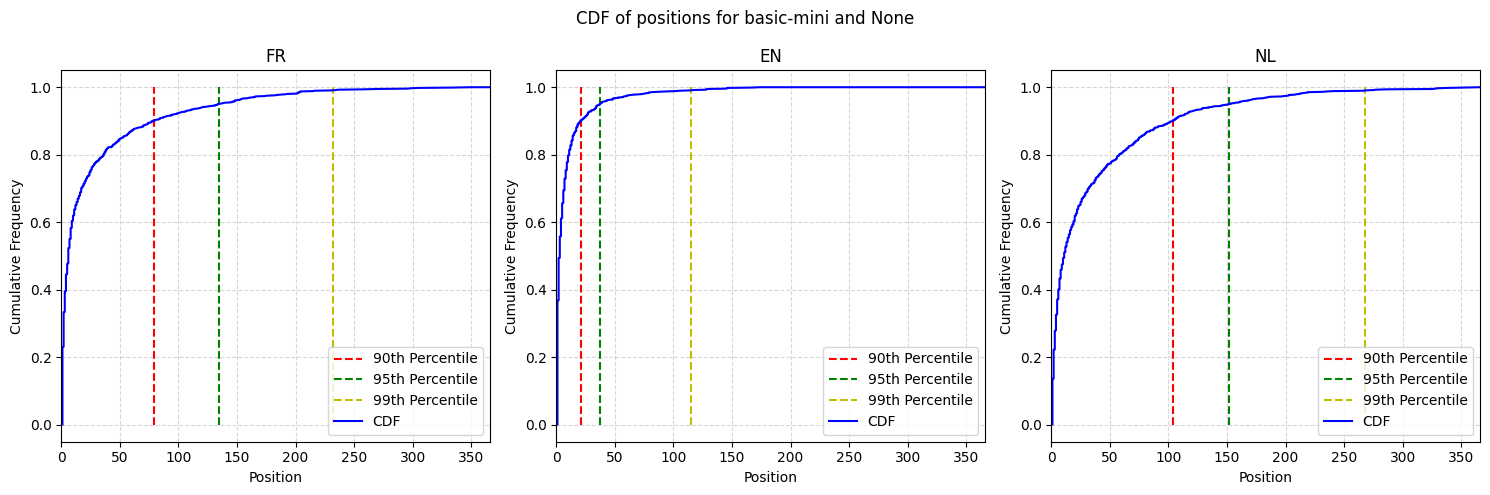

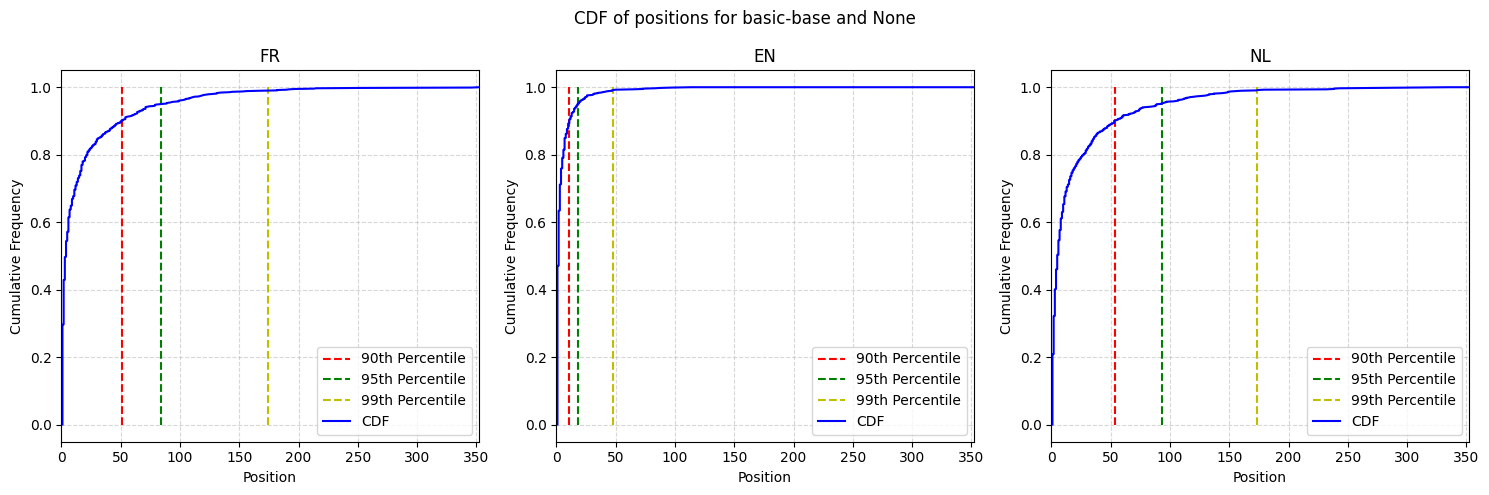

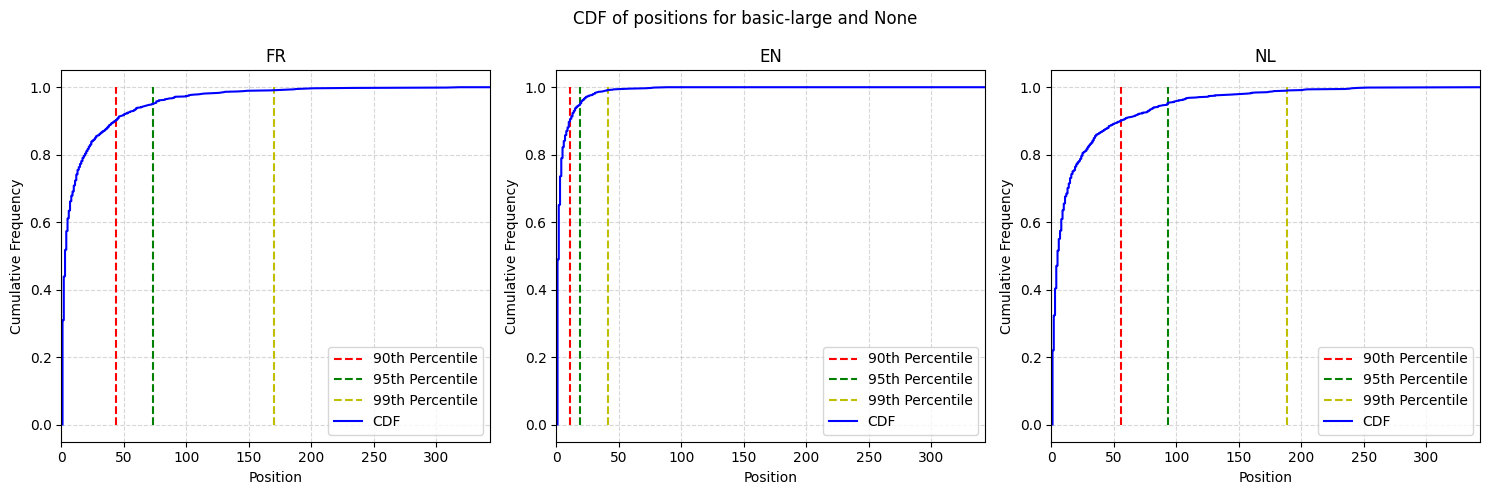

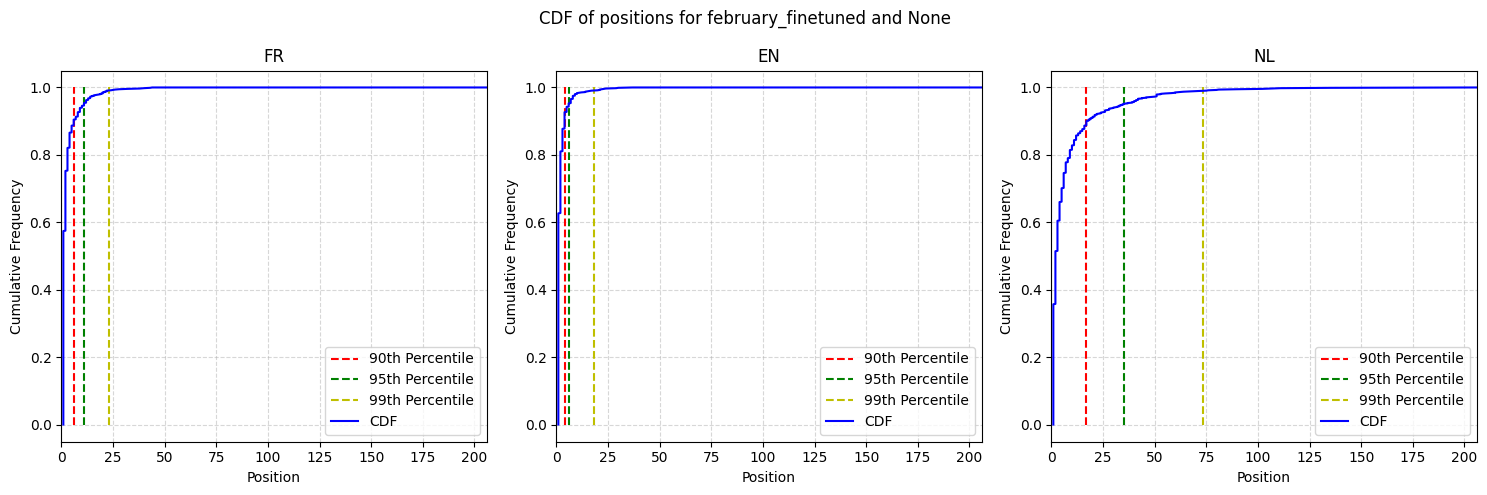

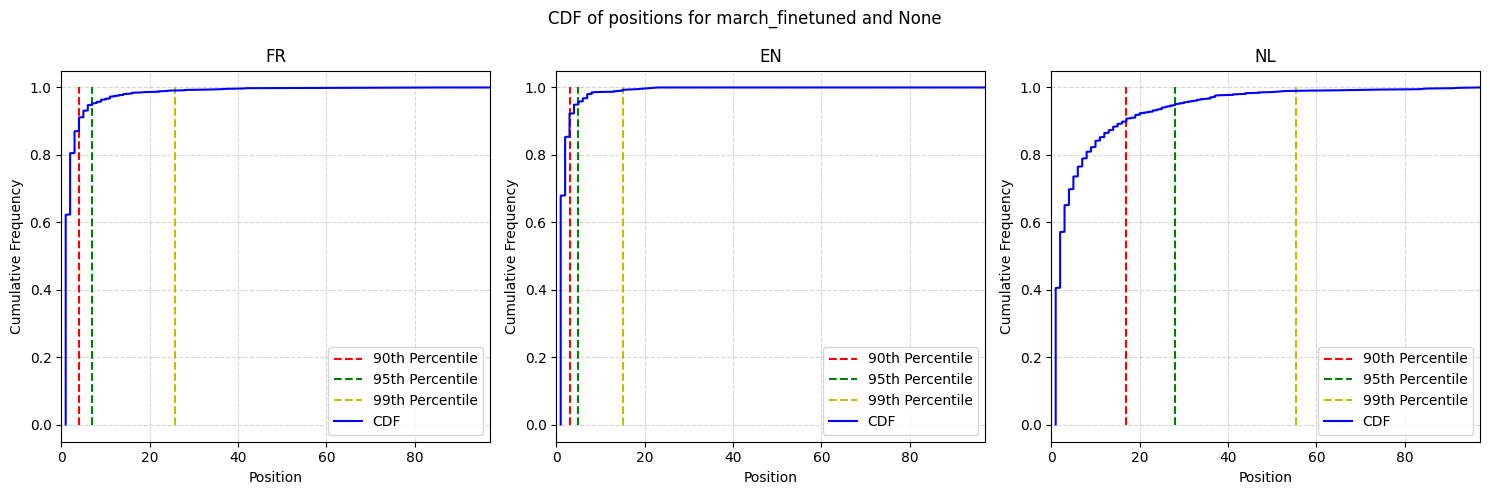

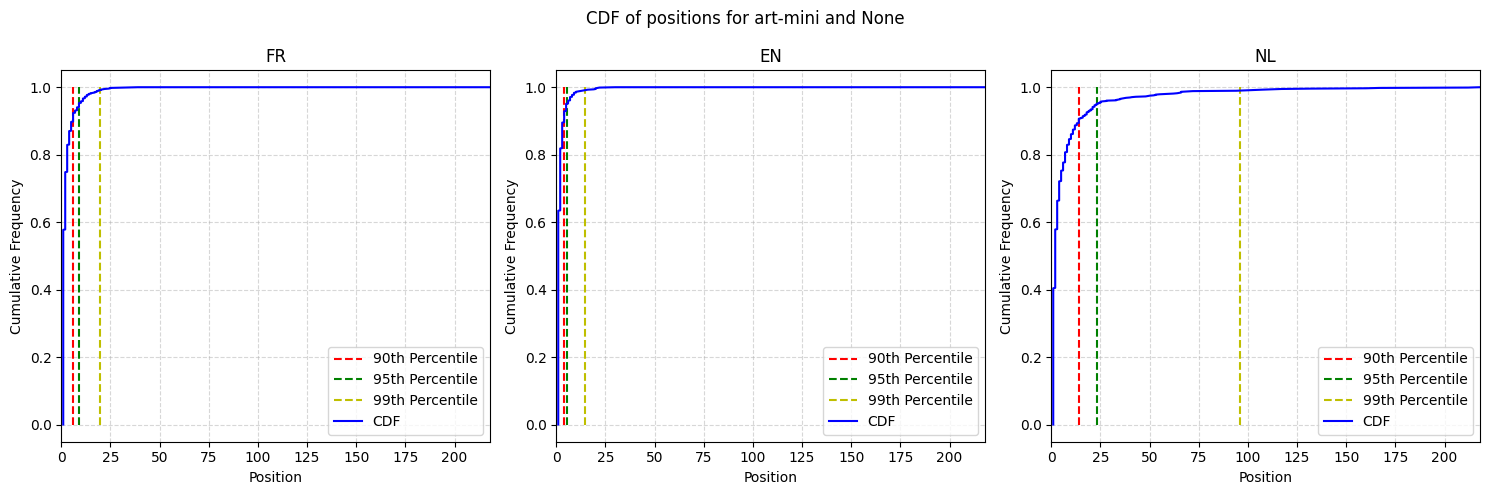

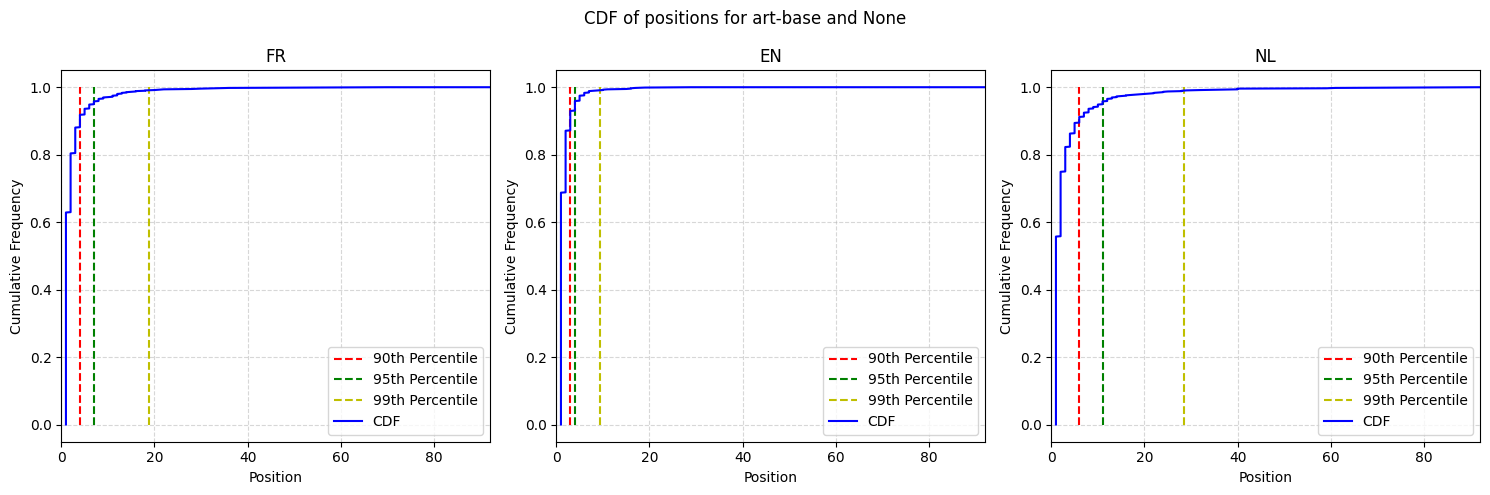

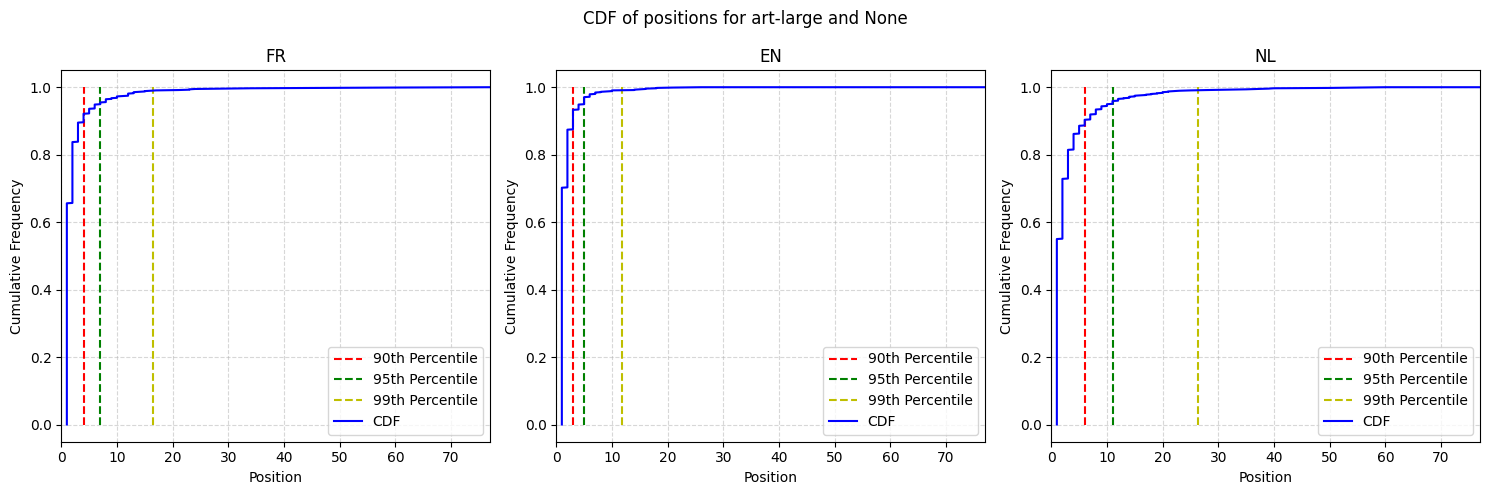

In [13]:
for model_name in models_name:
    cdf_positions(model_name, None)